## To reproduce ASIC AE EMD Pipeline results

In [1]:
import os
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import numba
import math

from utils.metrics import emd
from utils.metrics import hexMetric

import scipy
from scipy import stats, optimize, interpolate


from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, BatchNormalization, Activation, Average, Conv2D
from tensorflow.keras.models import Model
from keras.models import load_model
from tensorflow.keras.regularizers import l1_l2
        
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow as tf
from tensorflow.keras import backend as K

from datetime import date

## Read data from training CSVs with wafer information

In [32]:
import mplhep as hep
hep.style.use("CMS")
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [3]:
def load_data(inputFile):
    data=pd.read_csv(inputFile,usecols=[*range(0,48)])
    data_values=data.values
            
    return data_values

def load_eta(inputFile):
    data=pd.read_csv(inputFile,usecols=[48])
    data_values=data.to_numpy().flatten()
            
    return data_values

In [4]:
#Make new image directory for today's updates

today = date.today().strftime("%m_%d_%y")

img_directory=os.path.join('/ecoderemdvol/paper_plots/{}').format(today)

if not os.path.exists(img_directory):
    os.makedirs(img_directory)

In [5]:
test_1='/ecoderemdvol/paper_plots/emd_nn_input/files/verify_input_calQ.csv'
test_2='/ecoderemdvol/paper_plots/emd_nn_input/files/verify_decoded_calQ.csv'

arrange443 = np.array([0,16, 32,
                       1,17, 33,
                       2,18, 34,
                       3,19, 35,
                       4,20, 36,
                       5,21, 37,
                       6,22, 38,
                       7,23, 39,
                       8,24, 40,
                       9,25, 41,
                       10,26, 42,
                       11,27, 43,
                       12,28, 44,
                       13,29, 45,
                       14,30, 46,
                       15,31, 47])

In [6]:
calQ1     = load_data(test_1)
sumQ1     = calQ1.sum(axis=1)
calQ1     = calQ1[sumQ1>0]
sumQ1     = sumQ1[sumQ1>0]

calQ1_443 = (calQ1/np.expand_dims(sumQ1,-1))[:,arrange443].reshape(-1,4,4,3)

calQ2     = load_data(test_2)
sumQ2     = calQ2.sum(axis=1)
calQ2     = calQ2[sumQ2>0]
sumQ2     = sumQ2[sumQ2>0]

calQ2_443 = (calQ2/np.expand_dims(sumQ2,-1))[:,arrange443].reshape(-1,4,4,3)

#Generate True EMD for validation section of dataset
test_index= int(0.7*len(calQ1))
test_indices = range(test_index, len(calQ1))

In [7]:
truth_emd = np.array([emd(calQ1[i],calQ2[j]) for i, j in zip(test_indices,test_indices)])

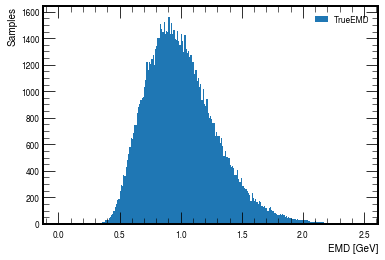

In [8]:
fig=plt.figure()
fig=plt.hist(truth_emd, alpha=1, bins=np.arange(0, 2.5,0.01), label='TrueEMD')
fig=plt.xlabel('EMD [GeV]')
fig=plt.ylabel('Samples')
fig=plt.legend()
plt.savefig(os.path.join(img_directory,'TrueEMD.png'),dpi=600)
plt.show()

In [9]:
#Load best emd model 

model_path='/ecoderemdvol/best_emd/ae_mse_lphe.h5'

In [10]:
X1 = calQ1_443
X2 = calQ2_443

X1_test = X1[test_index:]
X2_test = X2[test_index:]

model = tf.keras.models.load_model(model_path);

2023-07-28 08:48:35.426745: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-07-28 08:48:35.426787: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-28 08:48:35.426818: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ecoder-emd-pod): /proc/driver/nvidia/version does not exist
2023-07-28 08:48:35.426980: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
pred_emd = model.predict((X1_test, X2_test));

In [12]:
#Save data for later

emd_nn_data = pd.DataFrame(columns = ['truth','pred'])
emd_nn_data['truth'] = truth_emd
emd_nn_data['pred'] = pred_emd
emd_nn_data.to_csv('/ecoderemdvol/paper_plots/emd_nn_data.csv')

In [13]:
#Load saved data

"""
emd_nn_data = pd.read_csv('/ecoderemdvol/paper_plots/emd_nn_data.csv')
truth_emd = emd_nn_data['truth'].values
pred_emd = emd_nn_data['pred'].values
"""

"\nemd_nn_data = pd.read_csv('/ecoderemdvol/paper_plots/emd_nn_data.csv')\ntruth_emd = emd_nn_data['truth'].values\npred_emd = emd_nn_data['pred'].values\n"

In [14]:
resolution = 600

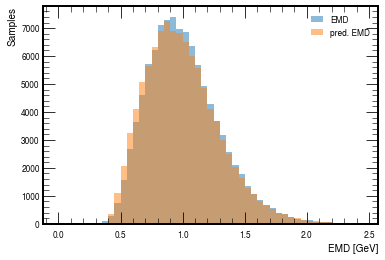

In [16]:
#Plots True EMD and Pred Emd Histogram
plt.close()  
fig=plt.figure()

#plt.xlim(-2.0,2.0)

fig=plt.hist(truth_emd, alpha=0.5, bins=np.arange(0, 2.5, 0.05), label='EMD')
fig=plt.hist(pred_emd, alpha=0.5, bins=np.arange(0, 2.5, 0.05), label='pred. EMD')
fig=plt.xlabel('EMD [GeV]')
fig=plt.ylabel('Samples')
fig=plt.legend()
plt.savefig(os.path.join(img_directory,'testing_EMD.pdf'),dpi=resolution)
plt.show()

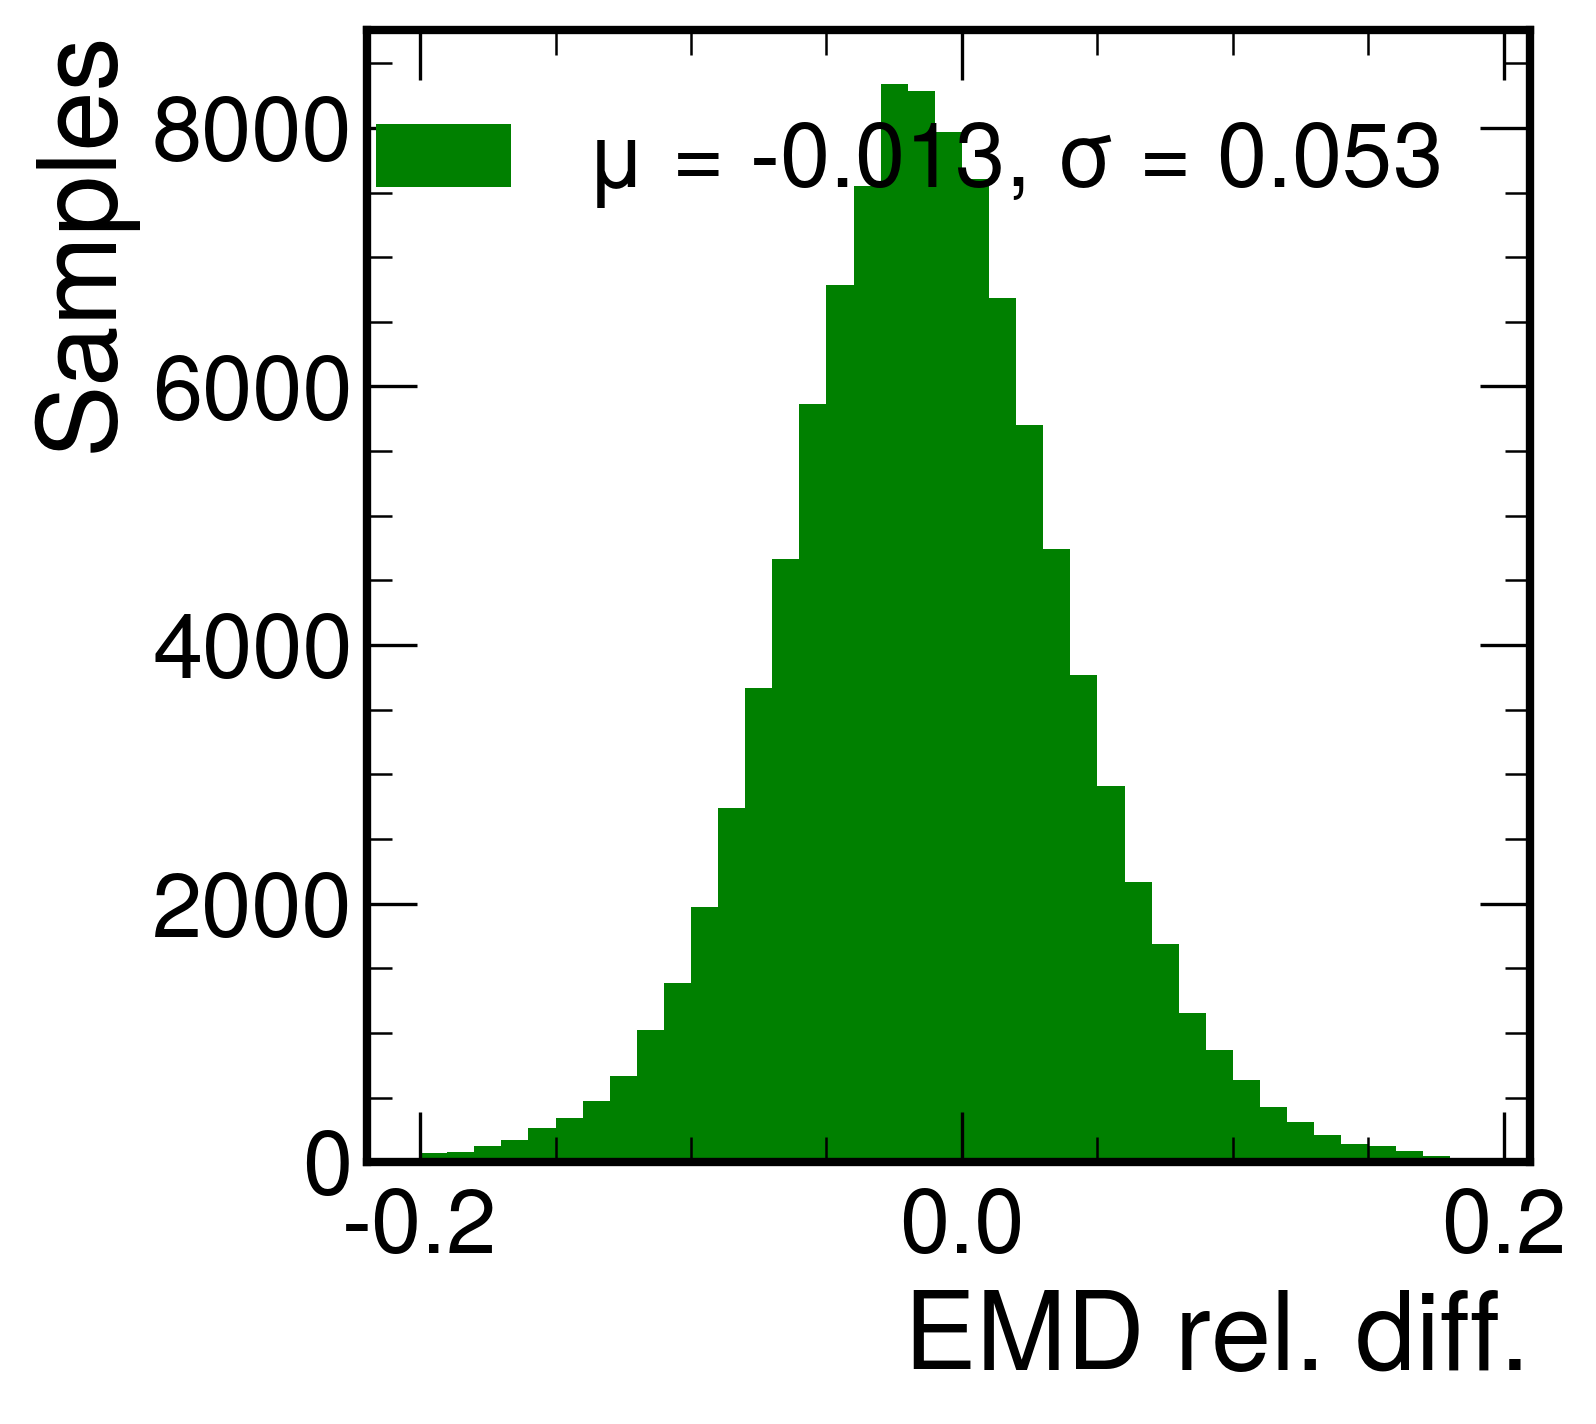

In [34]:
#Plot Relative Difference
plt.close()        
rel_diff = (pred_emd[pred_emd>0].flatten()-truth_emd[truth_emd>0].flatten())/truth_emd[truth_emd>0].flatten()
fig=plt.figure(figsize=(5,5))
fig=plt.hist(rel_diff, bins=np.arange(-0.2, 0.2, 0.01), color='green', label = r'$\mu$ = {:.3f}, $\sigma$ = {:.3f}'.format(np.mean(rel_diff), np.std(rel_diff)))
fig=plt.xlabel('EMD rel. diff.')
fig=plt.ylabel('Samples')
fig=plt.legend()
plt.savefig(os.path.join(img_directory,'testing_RelD.pdf'),dpi=resolution)
plt.show()

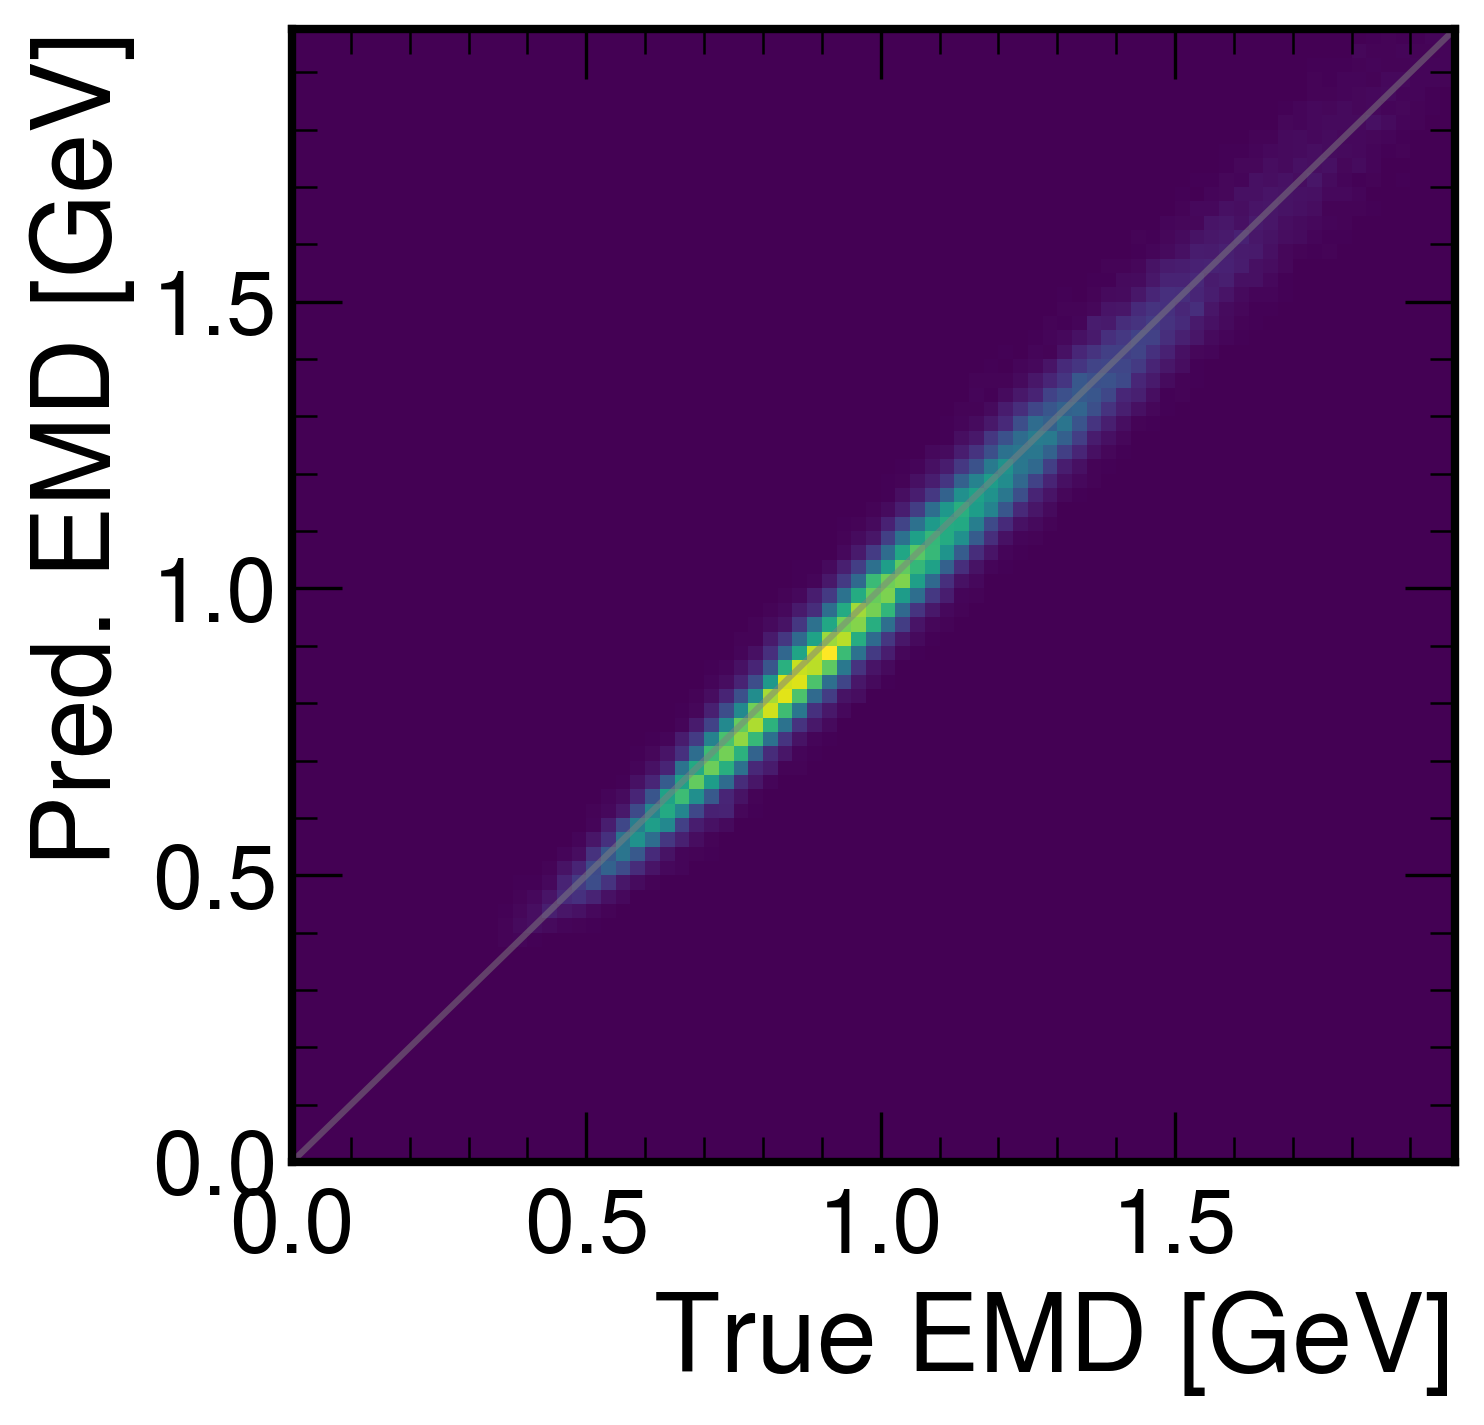

In [35]:
#Plot True EMD vs Pred Emd Graphic
plt.close()        
fig=plt.figure(figsize=(5,5)) 
x_bins = np.arange(0, 2, 0.025)
y_bins = np.arange(0, 2, 0.025)
plt.hist2d(truth_emd.flatten(), pred_emd.flatten(), bins=[x_bins,y_bins])
plt.plot([0, 2.5], [0, 2.5], color='gray', alpha=0.5)
plt.xlabel('True EMD [GeV]')
plt.ylabel('Pred. EMD [GeV]')
plt.savefig(os.path.join(img_directory,'testing_Correl.pdf'),dpi=resolution)
plt.show()

# Reproduce AE plots

In [19]:
input_data = load_data('/ecoderemdvol/QK/low_pt_high_eta_2/8x8_c8_S2_qK_RTL_emd_lphe/verify_input_calQ.csv')

In [20]:
ae_mse_output  = load_data('/ecoderemdvol/QK/low_pt_high_eta_3/8x8_c8_S2_qK_RTL_MSE/verify_decoded_calQ.csv')
ae_tele_output = load_data('/ecoderemdvol/QK/low_pt_high_eta_2/8x8_c8_S2_qK_RTL_tele/verify_decoded_calQ.csv')
ae_emd_output  = load_data('/ecoderemdvol/QK/low_pt_high_eta_2/8x8_c8_S2_qK_RTL_emd_lphe/verify_decoded_calQ.csv')

In [21]:
indices = range(len(input_data))

In [22]:
mse_emd = np.array([emd(input_data[i],ae_mse_output[j]) for i, j in zip(indices,indices)])

In [23]:
tele_emd = np.array([emd(input_data[i],ae_tele_output[j]) for i, j in zip(indices,indices)])

In [24]:
emd_emd = np.array([emd(input_data[i],ae_emd_output[j]) for i, j in zip(indices,indices)])

In [25]:
df = pd.DataFrame(columns=['mse_loss_emd','tele_loss_emd','emd_nn_loss_emd','eta','occ'])

# Plot EMD[AE_input,AE_output] vs 3 metrics: occupancy and sum of charges, and wafer $\eta$

In [26]:
#occupancy of trigger cells in wafers with one minimum ionizing particle
occupancy_1MT = np.count_nonzero(input_data.reshape(len(input_data),48)>1.,axis=1)

#wafer eta of data

eta = load_eta('/ecoderemdvol/QK/low_pt_high_eta_2/8x8_c8_S2_qK_RTL_emd_lphe/verify_input_calQ.csv')

In [27]:
x_labels = [r'Occupancy[1 MIP$_{T}$] TCs',r'$|\eta|$']
legends = ['Weighted MSE loss','telescope loss', 'EMD NN loss']
image_name = ['occ','eta']

In [28]:
df['mse_loss_emd'] = mse_emd
df['tele_loss_emd'] = tele_emd
df['emd_nn_loss_emd'] = emd_emd
df['eta'] = eta
df['occ'] = occupancy_1MT

In [29]:
df.to_csv('/ecoderemdvol/paper_plots/ae_emd_data.csv')

In [30]:
#to read directly on reruns

"""
ae_emd_data =  pd.read_csv('/ecoderemdvol/paper_plots/ae_emd_data.csv')
mse_emd = ae_emd_data['mse_loss_emd'].values
tele_emd = ae_emd_data['tele_loss_emd'].values
emd_emd = ae_emd_data['emd_loss_emd'].values
eta = ae_emd_data['eta'].values
occ = ae_emd_data[occ'].values
"""

"\nae_emd_data =  pd.read_csv('/ecoderemdvol/paper_plots/ae_emd_data.csv')\nmse_emd = ae_emd_data['mse_loss_emd'].values\ntele_emd = ae_emd_data['tele_loss_emd'].values\nemd_emd = ae_emd_data['emd_loss_emd'].values\neta = ae_emd_data['eta'].values\nocc = ae_emd_data[occ'].values\n"

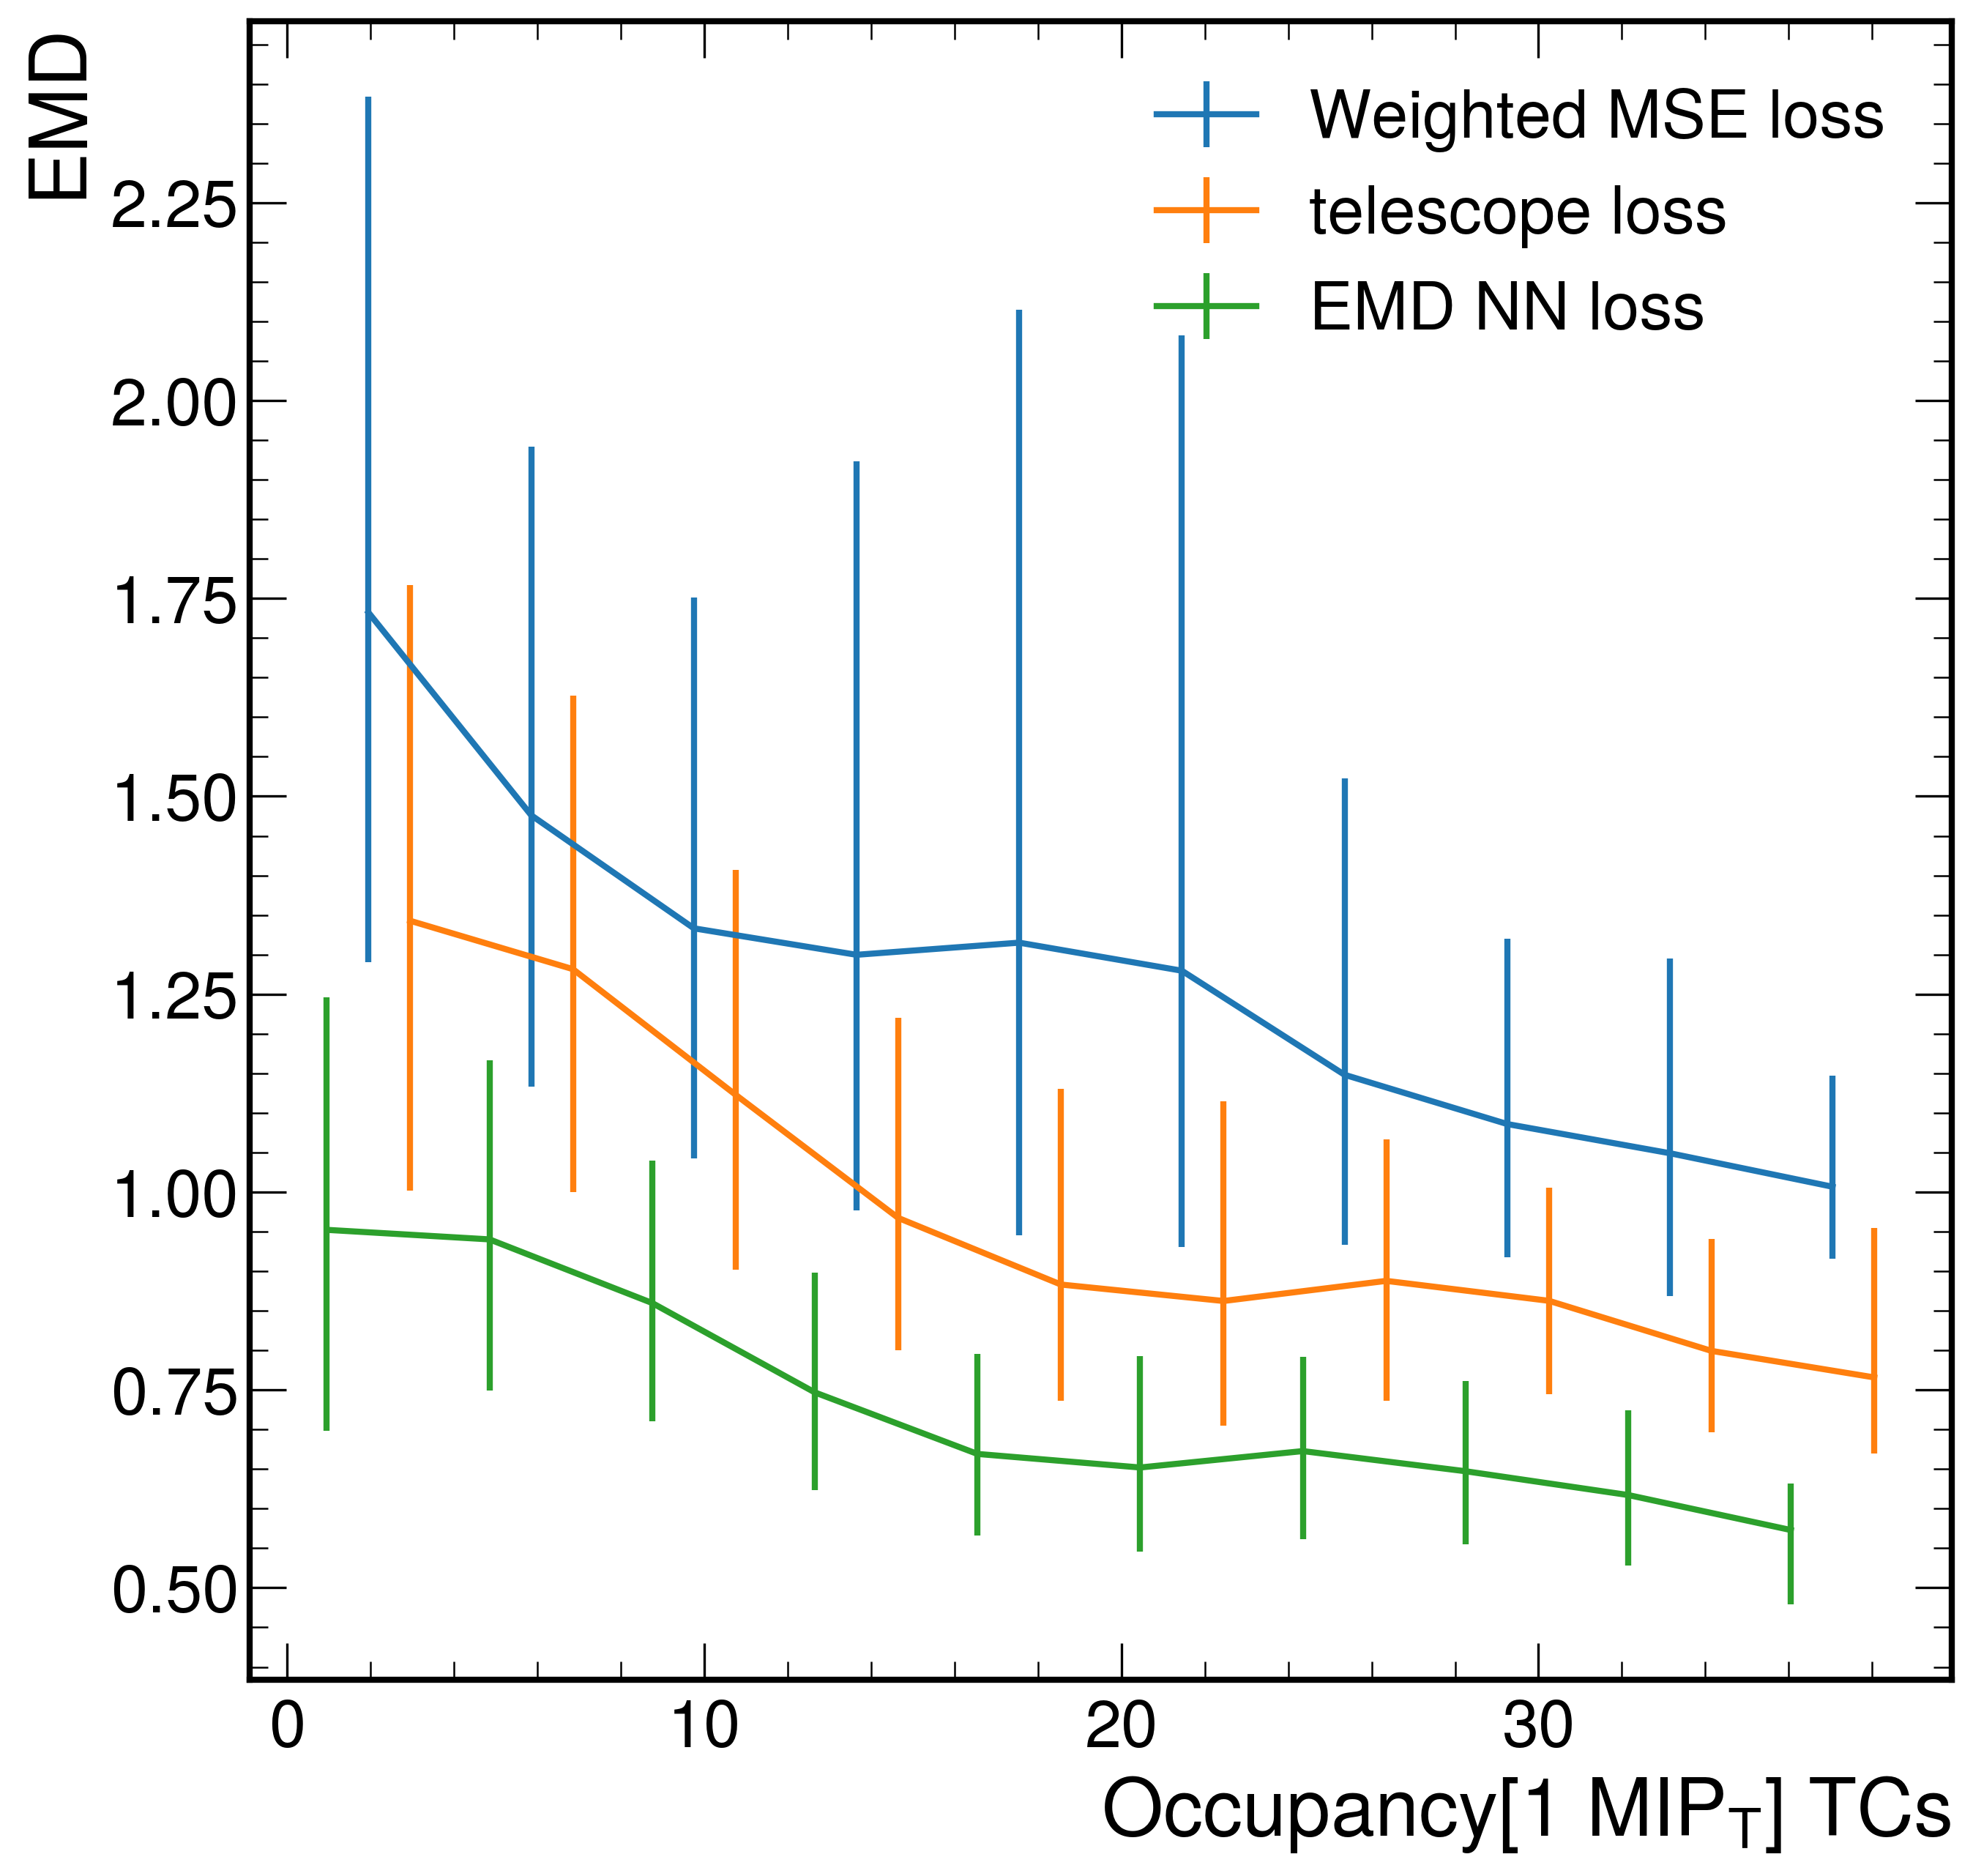

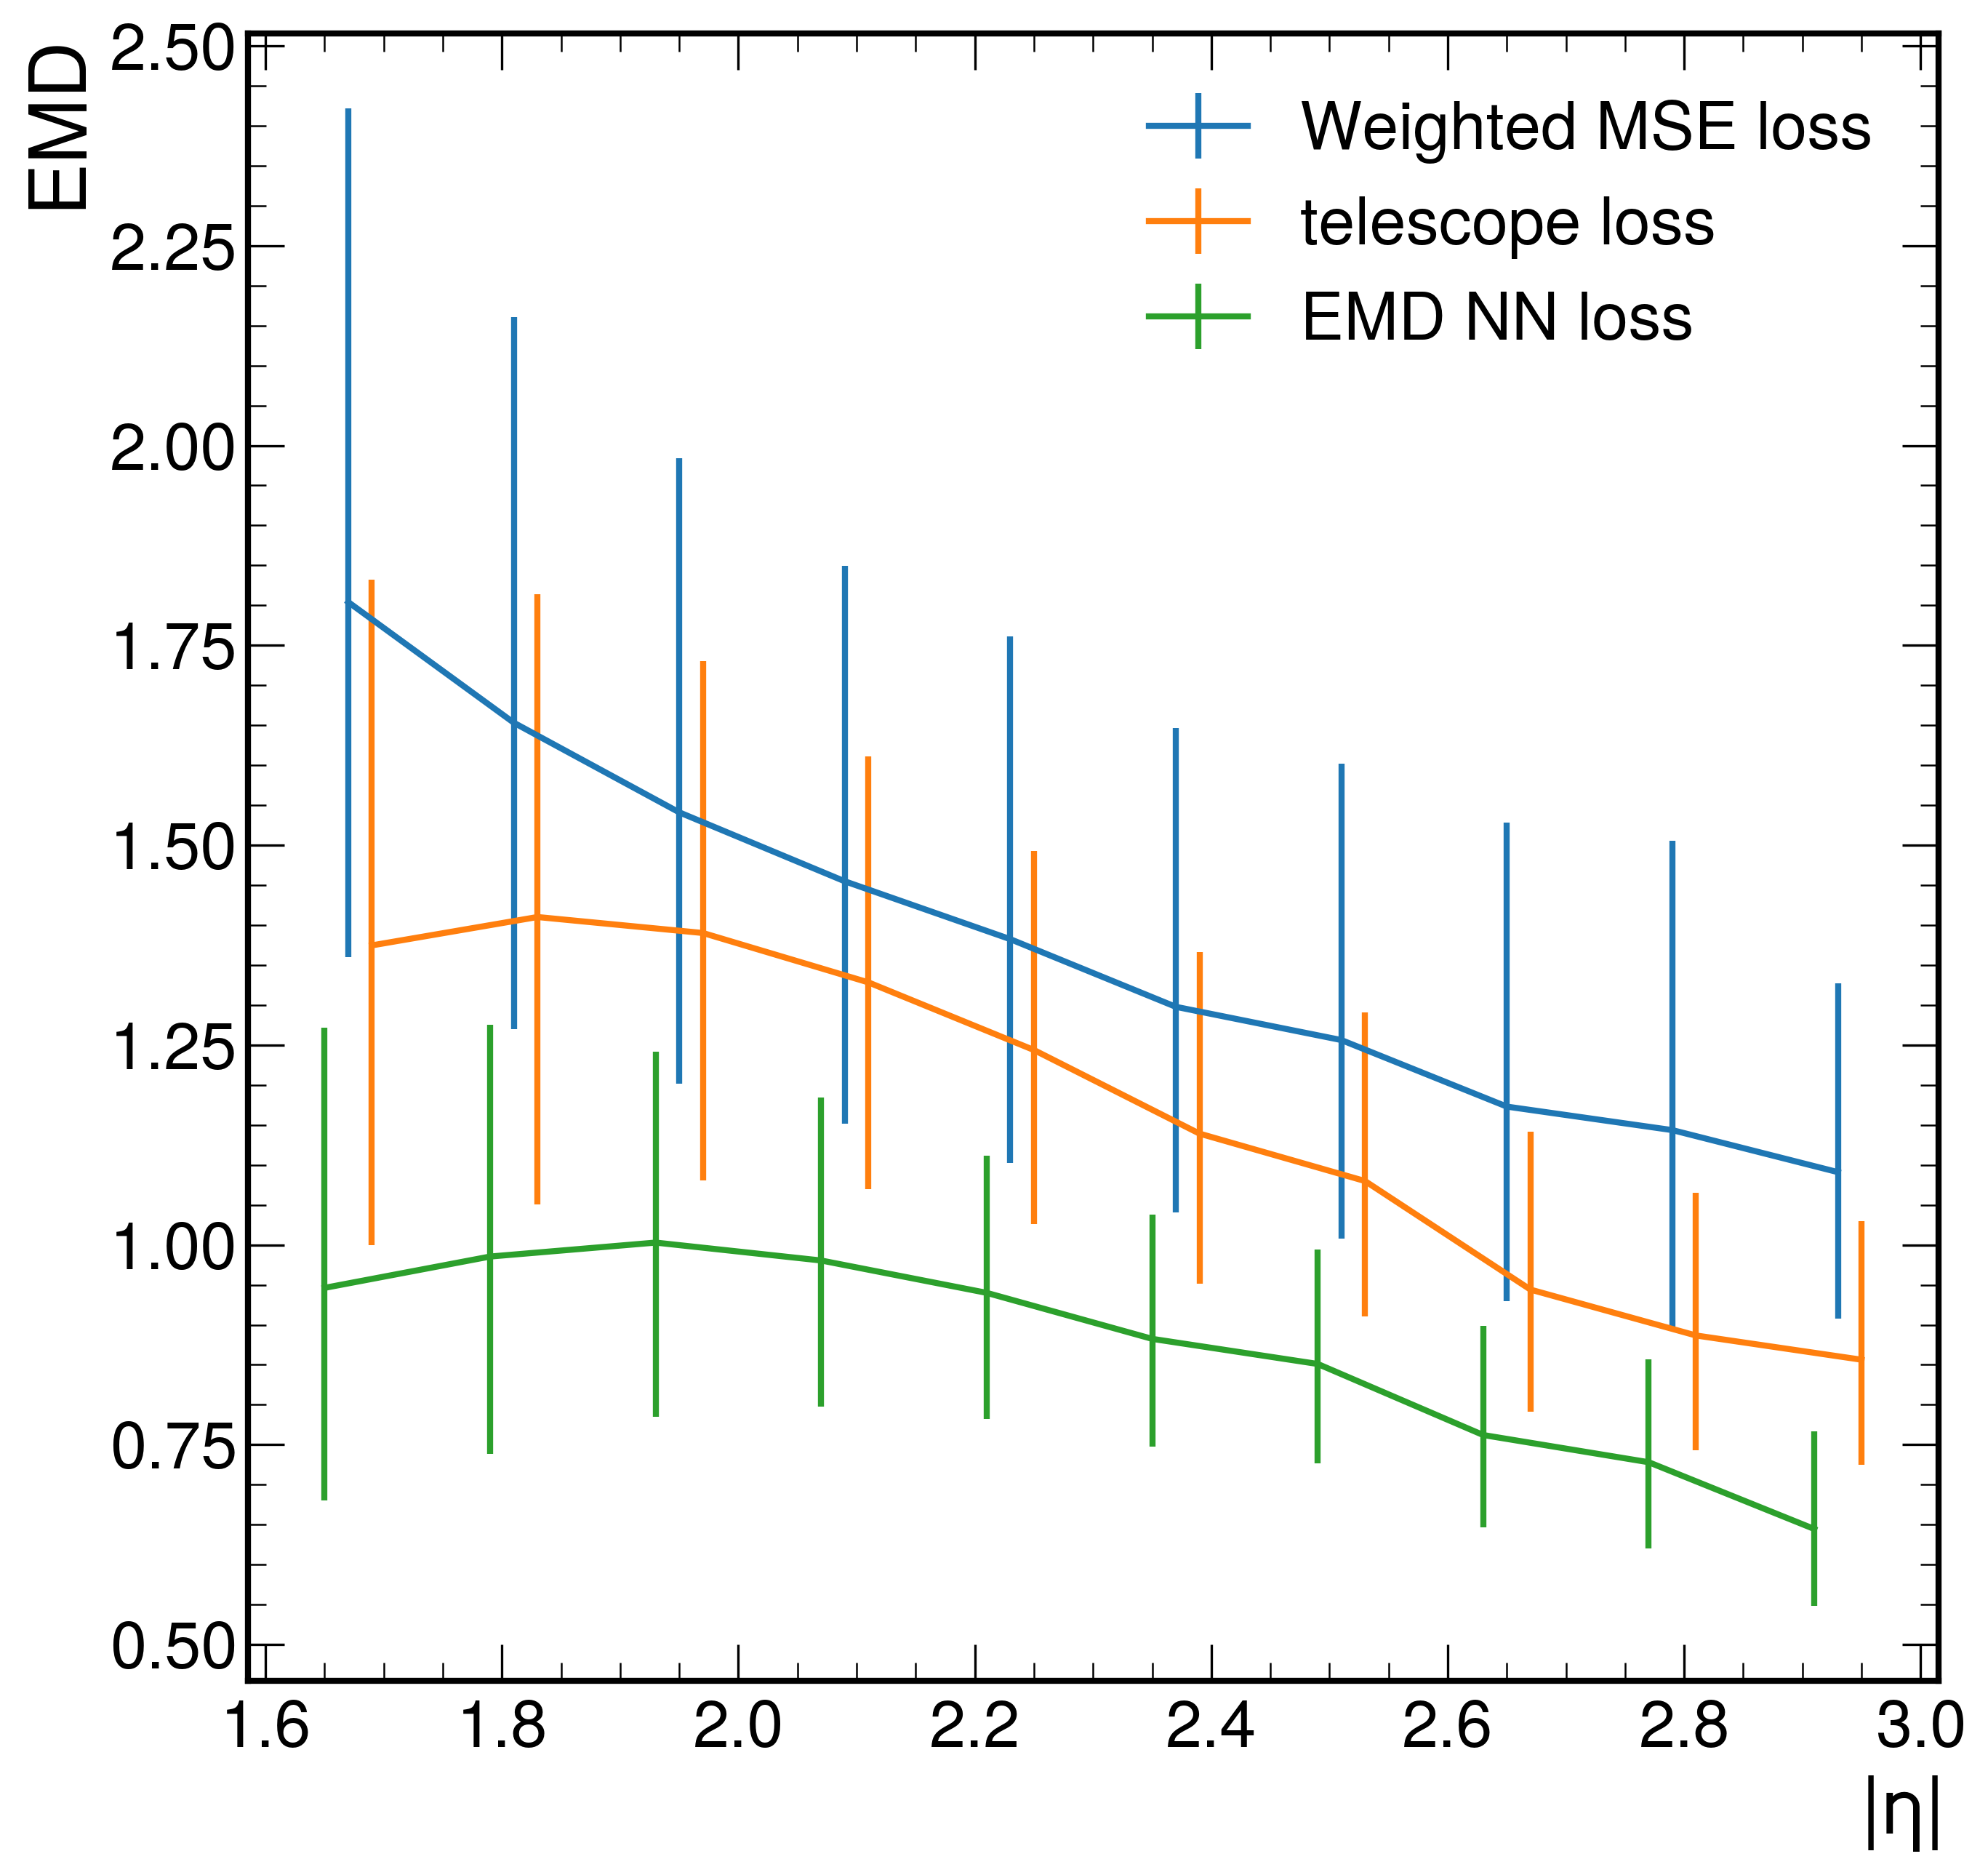

In [33]:
for x_it, x in enumerate((occupancy_1MT, eta)):
    
    offsets = [0,0.02,-0.02]
    
    for y_it,y in enumerate((mse_emd,tele_emd, emd_emd)):
        
        nbins=10
        stats=True
        lims = (x.min(),x.max())
        if x_it ==0:
            offsets = [0,1,-1]
        if x_it == 1:
            lims = (1.6,3.0)
        median_result = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5))
        lo_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5-0.68/2))
        hi_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5+0.68/2))
        median = np.nan_to_num(median_result.statistic)
        hi = np.nan_to_num(hi_result.statistic)
        lo = np.nan_to_num(lo_result.statistic)
        hie = hi-median
        loe = median-lo
        bin_edges = median_result.bin_edges
        bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
        
        off = offsets[y_it]

        plt.errorbar(x=bin_centers + off , y=median, yerr=[loe,hie],label = legends[y_it], linewidth = 2, elinewidth = 2)
    plt.xlabel(x_labels[x_it])
    plt.ylabel('EMD')
    plt.legend()
    plt.savefig(os.path.join(img_directory,image_name[x_it]+'.pdf'))
    plt.show()
    plt.close()